In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
import gc
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import  plot_qini_curve, plot_uplift_curve
pd.options.display.max_columns = None



# Object For Preprocessing

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class PrepocessingDataSetLetu():
    def __init__(self,  cat_vars = ['lftm_type','SEGMENT_N'
                                ,	'SUB_EMAIL'
                                , 'Тип карты'	
                                , 'Канал регистрации'
                                , 'NewComer'] 
                ,  for_norm = ['last_order_days',	'AMOUNT'
                                ,	'ORDERS'
                                ,	'AOV'	
                                ,'LTV_1M'
                                , 'AO_per_month'
                                , 'GET_Bonus'
                                ,	'USE_Bonus'
                                ,	'NON_SPEND_BONUS'
                                ,	'BASE_GET_Bonus'
                                ,	'BASE_USE_Bonus'
                                ,	'Express_GET_Bonus'
                                ,	'Express_USE_Bonus'
                                ,	'Camp_GET_Bonus'
                                ,	'REG_GET_Bonus'	
                                , 'Camp_BASE_GET_Bonus'
                                ,	'REG_BASE_GET_Bonus'
                                , 'AVG_USE_BONUS'
                                ,	'DISC_AMOUNT'
                                ,	'DISC_ORDERS'
                                , 'BASE_AVG_USE_BONUS'
                                ,	'BASE_DISC_AMOUNT'
                                ,	'BASE_DISC_ORDERS'
                                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                                ,'min_days_between', 'max_days_between', 'avg_days_between']
                , age = 'AGE'
               
            ):
            self.cat_vars = cat_vars
            self.for_norm = for_norm
            self.age = age
            self.scaler = None#StandardScaler()
            self.ohe = None#OneHotEncoder()
            self.ohe_solomodel = None#OneHotEncoder()
            self.med = None


    def fit(self, df):
        Y_var = df[['target','treat']]
        X_var = df.drop(['target','treat'], axis = 1)
        self.ohe = OneHotEncoder()
        self.scaler = StandardScaler()
        self.ohe_solomodel = OneHotEncoder()
        self.ohe.fit(X_var[self.cat_vars].values)
        self.med = X_var[self.age].median()
        self.scaler.fit(X_var[self.for_norm].values)
        self.ohe_solomodel.fit(Y_var.treat.values.reshape(-1, 1))
        del X_var, Y_var


    def preprocessing_data(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values                                            
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()
                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var  


    
    def preprocessing_data_solomodel(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values    
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()


                        if(self.ohe_solomodel is None):
                            self.ohe_solomodel = OneHotEncoder()
                            res = self.ohe_solomodel.fit_transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        else:
                            res = self.ohe_solomodel.transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)

                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var

In [3]:
def get_metrics(target, treat, uplift, k):
    return uplift_at_k(target, uplift, treat, strategy='overall', k=k) , uplift_at_k(target, uplift, treat, strategy='by_group', k=k) , qini_auc_score(target, uplift, treat), uplift_auc_score(target, uplift, treat)


def get_report(target, treat, uplift, plot_path = '', k =0.3):
    """
    Return:
        * uplift_at_k_overall
        * plift_at_k_group
        * qini_score
        * uplift_score

        Print qini, uplift plots
    """
    uplift_overall, uplift_group, qini_score, uplift_score = get_metrics(target, treat, uplift, k)                   
    print(f'UpLift at 30%: overall - {round(uplift_overall, 6)}, grouped - {round(uplift_group, 6)}.\nQini AUC Score: {round(qini_score, 6)}; UpLift AUC Score: {round(uplift_score, 6)}')

    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax[0].set_title('Qini Curve')
    ax[1].set_title('UpLift Curve')
    plot_qini_curve(target , uplift, treatment=treat, ax = ax[0], perfect=False)
    gc.collect()
    plot_uplift_curve(target , uplift, treatment=treat, ax = ax[1], perfect=False)
    gc.collect()
    gc.collect()
    gc.collect()
    plt.savefig(f"Plots/Base model Split.png")
    return uplift_overall, uplift_group, qini_score, uplift_score

# Базовая модель

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
df_subm.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.fit(pd.concat([df, df_subm]))
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 


C:\Users\Kirill\AppData\Local\Temp\ipykernel_17232\2971734590.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_subm = pd.read_csv(r'uplift_subm_dataset.zip'


,SEGMENT_N,SUB_EMAIL,target,treat,lftm_type,NewComer,Тип карты,Канал регистрации,AGE,AMOUNT,ORDERS,AOV,last_order_days,LTV_1M,AO_per_month,GET_Bonus,USE_Bonus,NON_SPEND_BONUS,BASE_GET_Bonus,BASE_USE_Bonus,Express_GET_Bonus,Express_USE_Bonus,Camp_GET_Bonus,REG_GET_Bonus,Camp_BASE_GET_Bonus,REG_BASE_GET_Bonus,AVG_DIS,AVG_USE_BONUS,DISC_AMOUNT,DISC_ORDERS,BASE_AVG_DIS,BASE_AVG_USE_BONUS,BASE_DISC_AMOUNT,BASE_DISC_ORDERS,Express_AVG_DIS,Express_AVG_USE_BONUS,Express_DISC_AMOUNT,Express_DISC_ORDERS,min_days_between,max_days_between,avg_days_between
7727314307,3,Да,0,0,NewComer,1,Как карточное платежное средство,Розница,NaN,3403.4,2.0,1701.7,50.0,850.85,0.50,536.0,502.0,34.0,36.0,2.0,500.0,500.0,NaN,36.0,NaN,36.0,0.133248,502.0,3265.4,1.0,0.000612,2.0,3265.4,1.0,0.132788,500.0,3265.4,1.0,-5.0,-5.0,-5.0
7721696179,2,Нет,0,0,NewComer,0,Без возможности оплаты,Ecomm,51.0,NaN,0.0,NaN,NaN,NaN,0.00,1300.0,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7727261180,-1,Да,0,0,NewComer,1,Как карточное платежное средство,Ecomm,32.0,NaN,4.0,NaN,8.0,NaN,1.00,4000.0,2500.0,1500.0,NaN,NaN,4000.0,2500.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,-38.0,0.0,-12.0
7725642339,1,Нет,0,1,NewComer,0,Как карточное платежное средство,Ecomm,NaN,959.2,1.0,959.2,68.0,239.80,0.25,510.0,NaN,NaN,10.0,NaN,500.0,NaN,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7720389215,1,Нет,0,1,NewComer,0,Без возможности оплаты,Розница,NaN,1603.0,1.0,1603.0,105.0,400.75,0.25,517.0,NaN,NaN,17.0,NaN,500.0,NaN,NaN,17.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
7727314307,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.36,0.084253,-0.077453,0.506414,-0.273705,-0.077453,0.506414,-0.130555,0.275526,-0.682034,-0.124791,-0.436670,-0.209122,0.306580,-0.972251,-0.063183,-0.972251,-0.063183,0.981466,0.076043,-0.403464,-0.519491,0.042222,-0.389077,0.884508,0.184259,-0.311862,0.953896,0.533180,0.779290,0.133248,0.000612,0.132788
7721696179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.51,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,1.982875,-1.417073,-0.790435,-0.458927,-0.447166,2.187232,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7727261180,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.32,-1.362934,-0.703778,1.960542,-0.826168,-0.703778,1.960542,9.451803,7.012203,3.991963,-0.458927,-0.447166,10.274926,8.046202,-0.972251,-0.719022,-0.972251,-0.719022,5.455291,-0.767560,0.937131,-0.536863,-0.711199,-1.830400,5.853015,-0.830178,1.524437,-0.327282,0.742982,0.471344,0.999200,0.000000,0.999200
7725642339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.36,0.704476,-0.527257,-0.220651,-0.514760,-0.527257,-0.220651,-0.202478,-1.417073,-0.790435,-0.366111,-0.447166,-0.209122,-1.628325,-0.972251,-0.536845,-0.972251,-0.536845,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7720389215,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.36,1.979379,-0.408779,-0.220651,-0.305749,-0.408779,-0.220651,-0.183114,-1.417073,-0.790435,-0.301140,-0.447166,-0.209122,-1.628325,-0.972251,-0.409320,-0.972251,-0.409320,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000


,target,treat
7727314307,0,0
7721696179,0,0
7727261180,0,0
7725642339,0,1
7720389215,0,1


In [5]:
df_subm.index.name = None
display(df.head())
X_data_subm, Y_data_subm = proc_data.preprocessing_data(df_subm)
display(X_data_subm.head()) 
display(Y_data_subm.head()) 


,SEGMENT_N,SUB_EMAIL,target,treat,lftm_type,NewComer,Тип карты,Канал регистрации,AGE,AMOUNT,ORDERS,AOV,last_order_days,LTV_1M,AO_per_month,GET_Bonus,USE_Bonus,NON_SPEND_BONUS,BASE_GET_Bonus,BASE_USE_Bonus,Express_GET_Bonus,Express_USE_Bonus,Camp_GET_Bonus,REG_GET_Bonus,Camp_BASE_GET_Bonus,REG_BASE_GET_Bonus,AVG_DIS,AVG_USE_BONUS,DISC_AMOUNT,DISC_ORDERS,BASE_AVG_DIS,BASE_AVG_USE_BONUS,BASE_DISC_AMOUNT,BASE_DISC_ORDERS,Express_AVG_DIS,Express_AVG_USE_BONUS,Express_DISC_AMOUNT,Express_DISC_ORDERS,min_days_between,max_days_between,avg_days_between
7727314307,3,Да,0,0,NewComer,1,Как карточное платежное средство,Розница,NaN,3403.4,2.0,1701.7,50.0,850.85,0.50,536.0,502.0,34.0,36.0,2.0,500.0,500.0,NaN,36.0,NaN,36.0,0.133248,502.0,3265.4,1.0,0.000612,2.0,3265.4,1.0,0.132788,500.0,3265.4,1.0,-5.0,-5.0,-5.0
7721696179,2,Нет,0,0,NewComer,0,Без возможности оплаты,Ecomm,51.0,NaN,0.0,NaN,NaN,NaN,0.00,1300.0,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7727261180,-1,Да,0,0,NewComer,1,Как карточное платежное средство,Ecomm,32.0,NaN,4.0,NaN,8.0,NaN,1.00,4000.0,2500.0,1500.0,NaN,NaN,4000.0,2500.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,-38.0,0.0,-12.0
7725642339,1,Нет,0,1,NewComer,0,Как карточное платежное средство,Ecomm,NaN,959.2,1.0,959.2,68.0,239.80,0.25,510.0,NaN,NaN,10.0,NaN,500.0,NaN,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7720389215,1,Нет,0,1,NewComer,0,Без возможности оплаты,Розница,NaN,1603.0,1.0,1603.0,105.0,400.75,0.25,517.0,NaN,NaN,17.0,NaN,500.0,NaN,NaN,17.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
7729487440,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.36,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,-0.783394,-1.417073,-0.790435,-0.458927,-0.447166,-0.808211,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7724975778,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.54,0.704476,-0.101322,0.506414,-0.294759,-0.101322,0.506414,0.693794,0.319358,0.226622,-0.143354,-0.368446,0.689511,0.306580,-0.972251,-0.099619,-0.972251,-0.099619,1.059220,-0.285926,-0.403464,-0.406576,-0.281052,-0.389077,0.884508,-0.251010,-0.311862,-0.016694,-0.515831,-0.320518,0.216450,0.007981,0.211479
7715433861,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.40,2.082750,0.225431,-0.220651,0.813087,0.225431,-0.220651,2.123955,0.268782,1.922779,0.014433,-0.447166,2.187232,0.306580,-0.972251,0.210083,-0.972251,0.210083,0.969504,0.536894,-0.403464,-0.536863,-0.711199,-1.830400,0.884508,0.738434,-0.311862,1.148014,0.742982,0.999252,0.090102,0.000000,0.090102
7728251646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.36,0.670019,-0.694760,-0.220651,-0.810260,-0.694760,-0.220651,-0.780628,-1.417073,-0.790435,-0.449645,-0.447166,-0.808211,-1.628325,-0.972251,-0.700804,-0.972251,-0.700804,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7711651230,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.25,0.463278,-0.176093,-0.220651,0.104743,-0.176093,-0.220651,0.956589,-0.405560,1.214984,-0.189762,-0.447166,0.989055,-0.467382,-0.972251,-0.190708,-0.972251,-0.190708,-0.226706,-0.026779,-0.403464,-0.536863,-0.711199,-1.830400,-0.440428,0.060615,-0.311862,1.148014,0.742982,0.999252,0.094714,0.000000,0.094714


,target,treat
7729487440,0,1
7724975778,0,0
7715433861,0,1
7728251646,0,1
7711651230,0,1


UpLift at 30%: overall - 0.004826, grouped - 0.004794.
Qini AUC Score: -0.001084; UpLift AUC Score: -0.000294


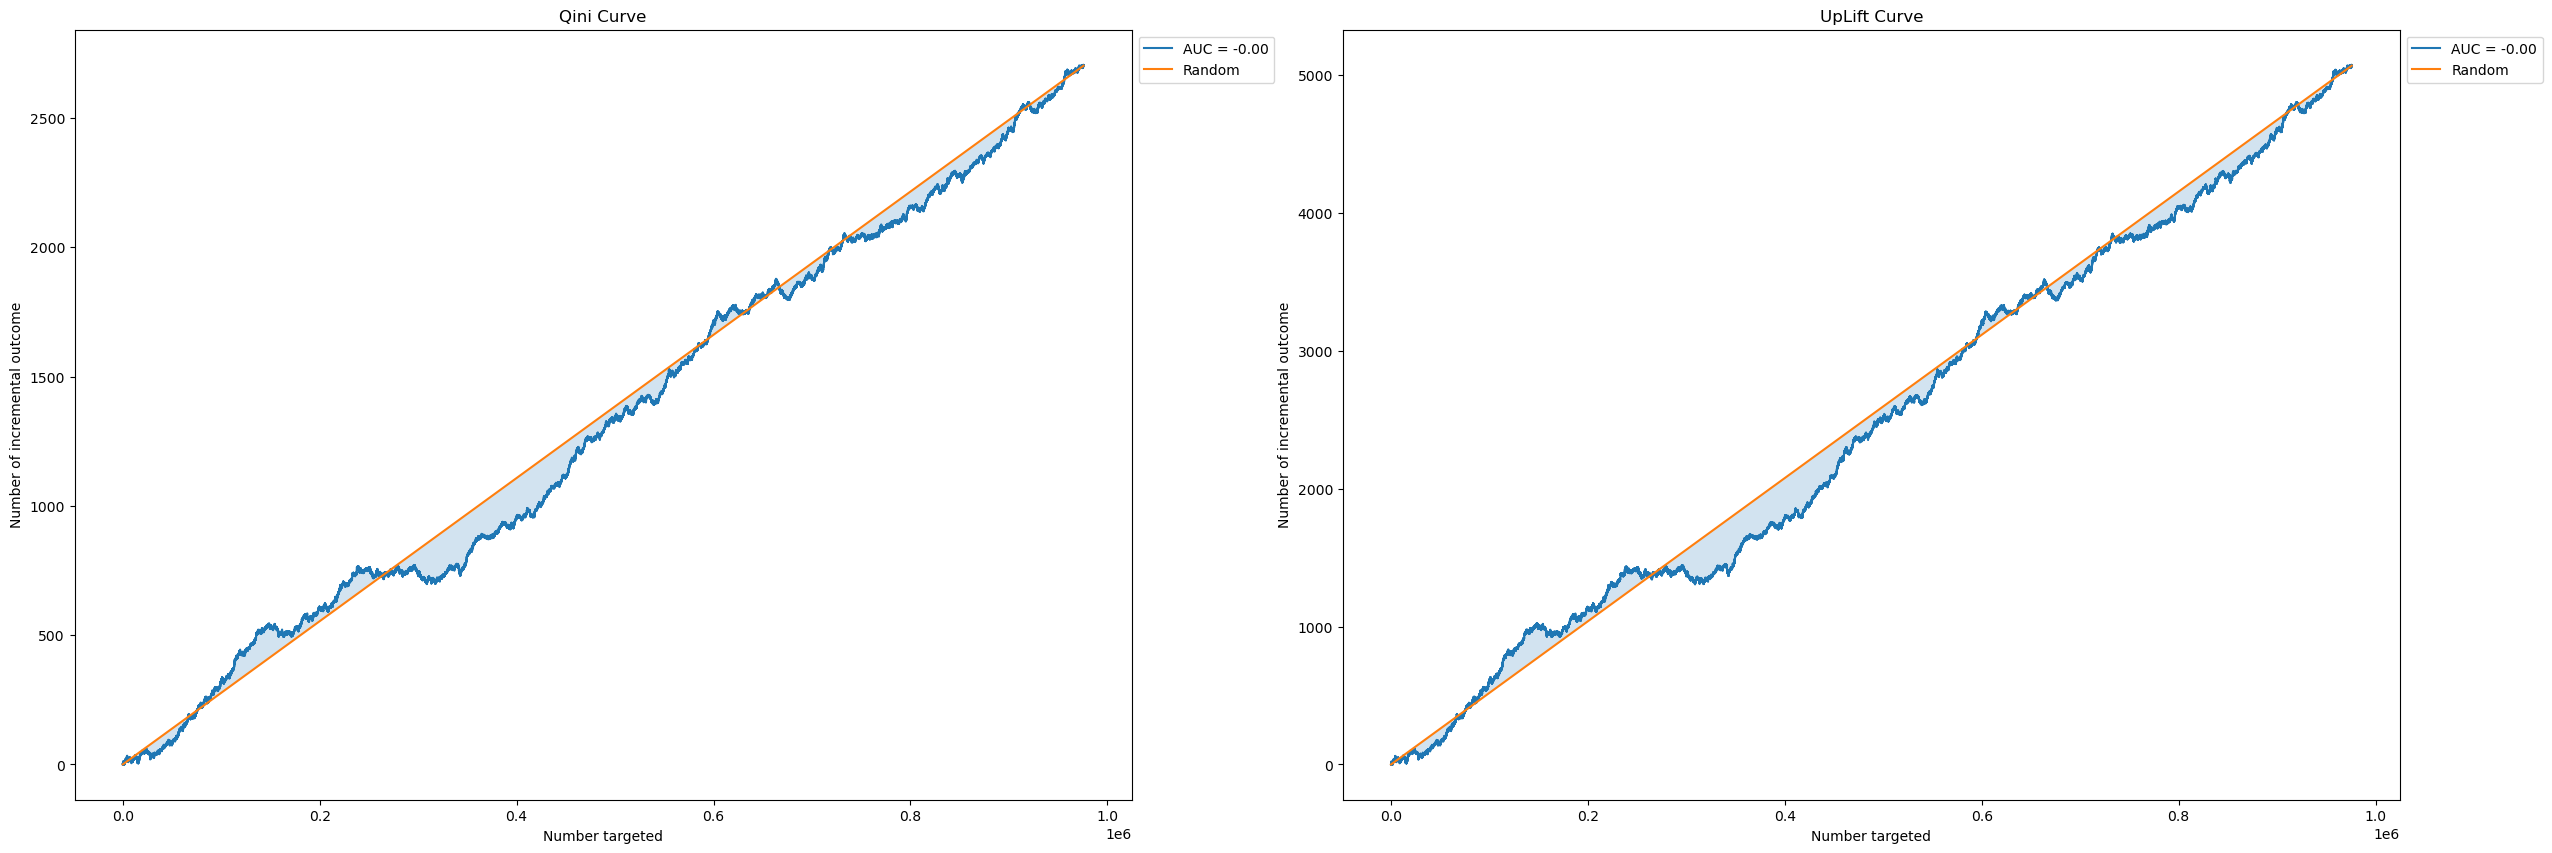

In [6]:
treat = Y_data_subm.treat.values
y = Y_data_subm.target.values
y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(y, treat, y_pred, 'Plots/Base model Subm Split.png')










## Subm Best Classifier Pipeline

In [7]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching_class.cloudpickle')


In [8]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [9]:
ranks.to_csv('evalml_class_res.csv', index = False)

In [10]:
ranks.head()

,pipeline_name,validation_score,percent_better_than_baseline,parameters
0,Stacked Ensemble Classification Pipeline,0.414692,inf,"{'Label Encoder': {'positive_label': None}, 'L..."
16,Random Forest Classifier w/ Label Encoder + Re...,0.414609,inf,"{'Label Encoder': {'positive_label': None}, 'I..."
17,LightGBM Classifier w/ Label Encoder + Replace...,0.406470,inf,"{'Label Encoder': {'positive_label': None}, 'I..."
18,XGBoost Classifier w/ Label Encoder + Replace ...,0.401770,inf,"{'Label Encoder': {'positive_label': None}, 'I..."
19,Random Forest Classifier w/ Label Encoder + Re...,0.394976,inf,"{'Label Encoder': {'positive_label': None}, 'I..."


In [11]:
ranks.shape

(13, 4)

In [12]:

ranks.head(10).to_excel('class_res.xlsx')

In [13]:
ranks.iloc[0, :].parameters

{'Label Encoder': {'positive_label': None},
 'Linear Pipeline - Label Encoder': {'positive_label': None},
 'Linear Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Linear Pipeline - Undersampler': {'sampling_ratio': 0.25,
  'min_samples': 100,
  'min_percentage': 0.1,
  'sampling_ratio_dict': None},
 'Linear Pipeline - Logistic Regression Classifier': {'penalty': 'l2',
  'C': 1.0,
  'n_jobs': -1,
  'multi_class': 'auto',
  'solver': 'lbfgs'},
 'Random Forest Pipeline - Label Encoder': {'positive_label': None},
 'Random Forest Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Random Forest Pip

In [14]:
best_clf = automl.best_pipeline
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [15]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
df_subm.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.fit(pd.concat([df, df_subm]))
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






C:\Users\Kirill\AppData\Local\Temp\ipykernel_17232\1440914459.py:6: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



,SEGMENT_N,SUB_EMAIL,target,treat,lftm_type,NewComer,Тип карты,Канал регистрации,AGE,AMOUNT,ORDERS,AOV,last_order_days,LTV_1M,AO_per_month,GET_Bonus,USE_Bonus,NON_SPEND_BONUS,BASE_GET_Bonus,BASE_USE_Bonus,Express_GET_Bonus,Express_USE_Bonus,Camp_GET_Bonus,REG_GET_Bonus,Camp_BASE_GET_Bonus,REG_BASE_GET_Bonus,AVG_DIS,AVG_USE_BONUS,DISC_AMOUNT,DISC_ORDERS,BASE_AVG_DIS,BASE_AVG_USE_BONUS,BASE_DISC_AMOUNT,BASE_DISC_ORDERS,Express_AVG_DIS,Express_AVG_USE_BONUS,Express_DISC_AMOUNT,Express_DISC_ORDERS,min_days_between,max_days_between,avg_days_between
7727314307,3,Да,0,0,NewComer,1,Как карточное платежное средство,Розница,NaN,3403.4,2.0,1701.7,50.0,850.85,0.50,536.0,502.0,34.0,36.0,2.0,500.0,500.0,NaN,36.0,NaN,36.0,0.133248,502.0,3265.4,1.0,0.000612,2.0,3265.4,1.0,0.132788,500.0,3265.4,1.0,-5.0,-5.0,-5.0
7721696179,2,Нет,0,0,NewComer,0,Без возможности оплаты,Ecomm,51.0,NaN,0.0,NaN,NaN,NaN,0.00,1300.0,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7727261180,-1,Да,0,0,NewComer,1,Как карточное платежное средство,Ecomm,32.0,NaN,4.0,NaN,8.0,NaN,1.00,4000.0,2500.0,1500.0,NaN,NaN,4000.0,2500.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,-38.0,0.0,-12.0
7725642339,1,Нет,0,1,NewComer,0,Как карточное платежное средство,Ecomm,NaN,959.2,1.0,959.2,68.0,239.80,0.25,510.0,NaN,NaN,10.0,NaN,500.0,NaN,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7720389215,1,Нет,0,1,NewComer,0,Без возможности оплаты,Розница,NaN,1603.0,1.0,1603.0,105.0,400.75,0.25,517.0,NaN,NaN,17.0,NaN,500.0,NaN,NaN,17.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52
7727314307,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.36,0.084253,-0.077453,0.506414,-0.273705,-0.077453,0.506414,-0.130555,0.275526,-0.682034,-0.124791,-0.436670,-0.209122,0.306580,-0.972251,-0.063183,-0.972251,-0.063183,0.981466,0.076043,-0.403464,-0.519491,0.042222,-0.389077,0.884508,0.184259,-0.311862,0.953896,0.533180,0.779290,0.133248,0.000612,0.132788,1.0,0.0
7721696179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.51,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,1.982875,-1.417073,-0.790435,-0.458927,-0.447166,2.187232,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000,1.0,0.0
7727261180,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.32,-1.362934,-0.703778,1.960542,-0.826168,-0.703778,1.960542,9.451803,7.012203,3.991963,-0.458927,-0.447166,10.274926,8.046202,-0.972251,-0.719022,-0.972251,-0.719022,5.455291,-0.767560,0.937131,-0.536863,-0.711199,-1.830400,5.853015,-0.830178,1.524437,-0.327282,0.742982,0.471344,0.999200,0.000000,0.999200,1.0,0.0
7725642339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.36,0.704476,-0.527257,-0.220651,-0.514760,-0.527257,-0.220651,-0.202478,-1.417073,-0.790435,-0.366111,-0.447166,-0.209122,-1.628325,-0.972251,-0.536845,-0.972251,-0.536845,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000,0.0,1.0
7720389215,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.36,1.979379,-0.408779,-0.220651,-0.305749,-0.408779,-0.220651,-0.183114,-1.417073,-0.790435,-0.301140,-0.447166,-0.209122,-1.628325,-0.972251,-0.409320,-0.972251,-0.409320,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000,0.0,1.0


,target,treat
7727314307,0,0
7721696179,0,0
7727261180,0,0
7725642339,0,1
7720389215,0,1


(944419, 53)
(944419,)


In [16]:
X_data_subm, Y_data_subm = proc_data.preprocessing_data_solomodel(df_subm)
treat_subm = Y_data_subm.treat.values
X_subm = X_data_subm.values
y_subm = Y_data_subm.target.values
display(X_data_subm.head()) 
display(Y_data_subm.head()) 
gc.collect()
print(X_subm.shape)
print(y_subm.shape)






,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52
7729487440,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.36,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,-0.783394,-1.417073,-0.790435,-0.458927,-0.447166,-0.808211,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000,0.0,1.0
7724975778,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.54,0.704476,-0.101322,0.506414,-0.294759,-0.101322,0.506414,0.693794,0.319358,0.226622,-0.143354,-0.368446,0.689511,0.306580,-0.972251,-0.099619,-0.972251,-0.099619,1.059220,-0.285926,-0.403464,-0.406576,-0.281052,-0.389077,0.884508,-0.251010,-0.311862,-0.016694,-0.515831,-0.320518,0.216450,0.007981,0.211479,1.0,0.0
7715433861,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.40,2.082750,0.225431,-0.220651,0.813087,0.225431,-0.220651,2.123955,0.268782,1.922779,0.014433,-0.447166,2.187232,0.306580,-0.972251,0.210083,-0.972251,0.210083,0.969504,0.536894,-0.403464,-0.536863,-0.711199,-1.830400,0.884508,0.738434,-0.311862,1.148014,0.742982,0.999252,0.090102,0.000000,0.090102,0.0,1.0
7728251646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.36,0.670019,-0.694760,-0.220651,-0.810260,-0.694760,-0.220651,-0.780628,-1.417073,-0.790435,-0.449645,-0.447166,-0.808211,-1.628325,-0.972251,-0.700804,-0.972251,-0.700804,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000,0.0,1.0
7711651230,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.25,0.463278,-0.176093,-0.220651,0.104743,-0.176093,-0.220651,0.956589,-0.405560,1.214984,-0.189762,-0.447166,0.989055,-0.467382,-0.972251,-0.190708,-0.972251,-0.190708,-0.226706,-0.026779,-0.403464,-0.536863,-0.711199,-1.830400,-0.440428,0.060615,-0.311862,1.148014,0.742982,0.999252,0.094714,0.000000,0.094714,0.0,1.0


,target,treat
7729487440,0,1
7724975778,0,0
7715433861,0,1
7728251646,0,1
7711651230,0,1


(975814, 53)
(975814,)


UpLift at 30%: overall - 0.005118, grouped - 0.005732.
Qini AUC Score: 0.001564; UpLift AUC Score: 0.000364


60

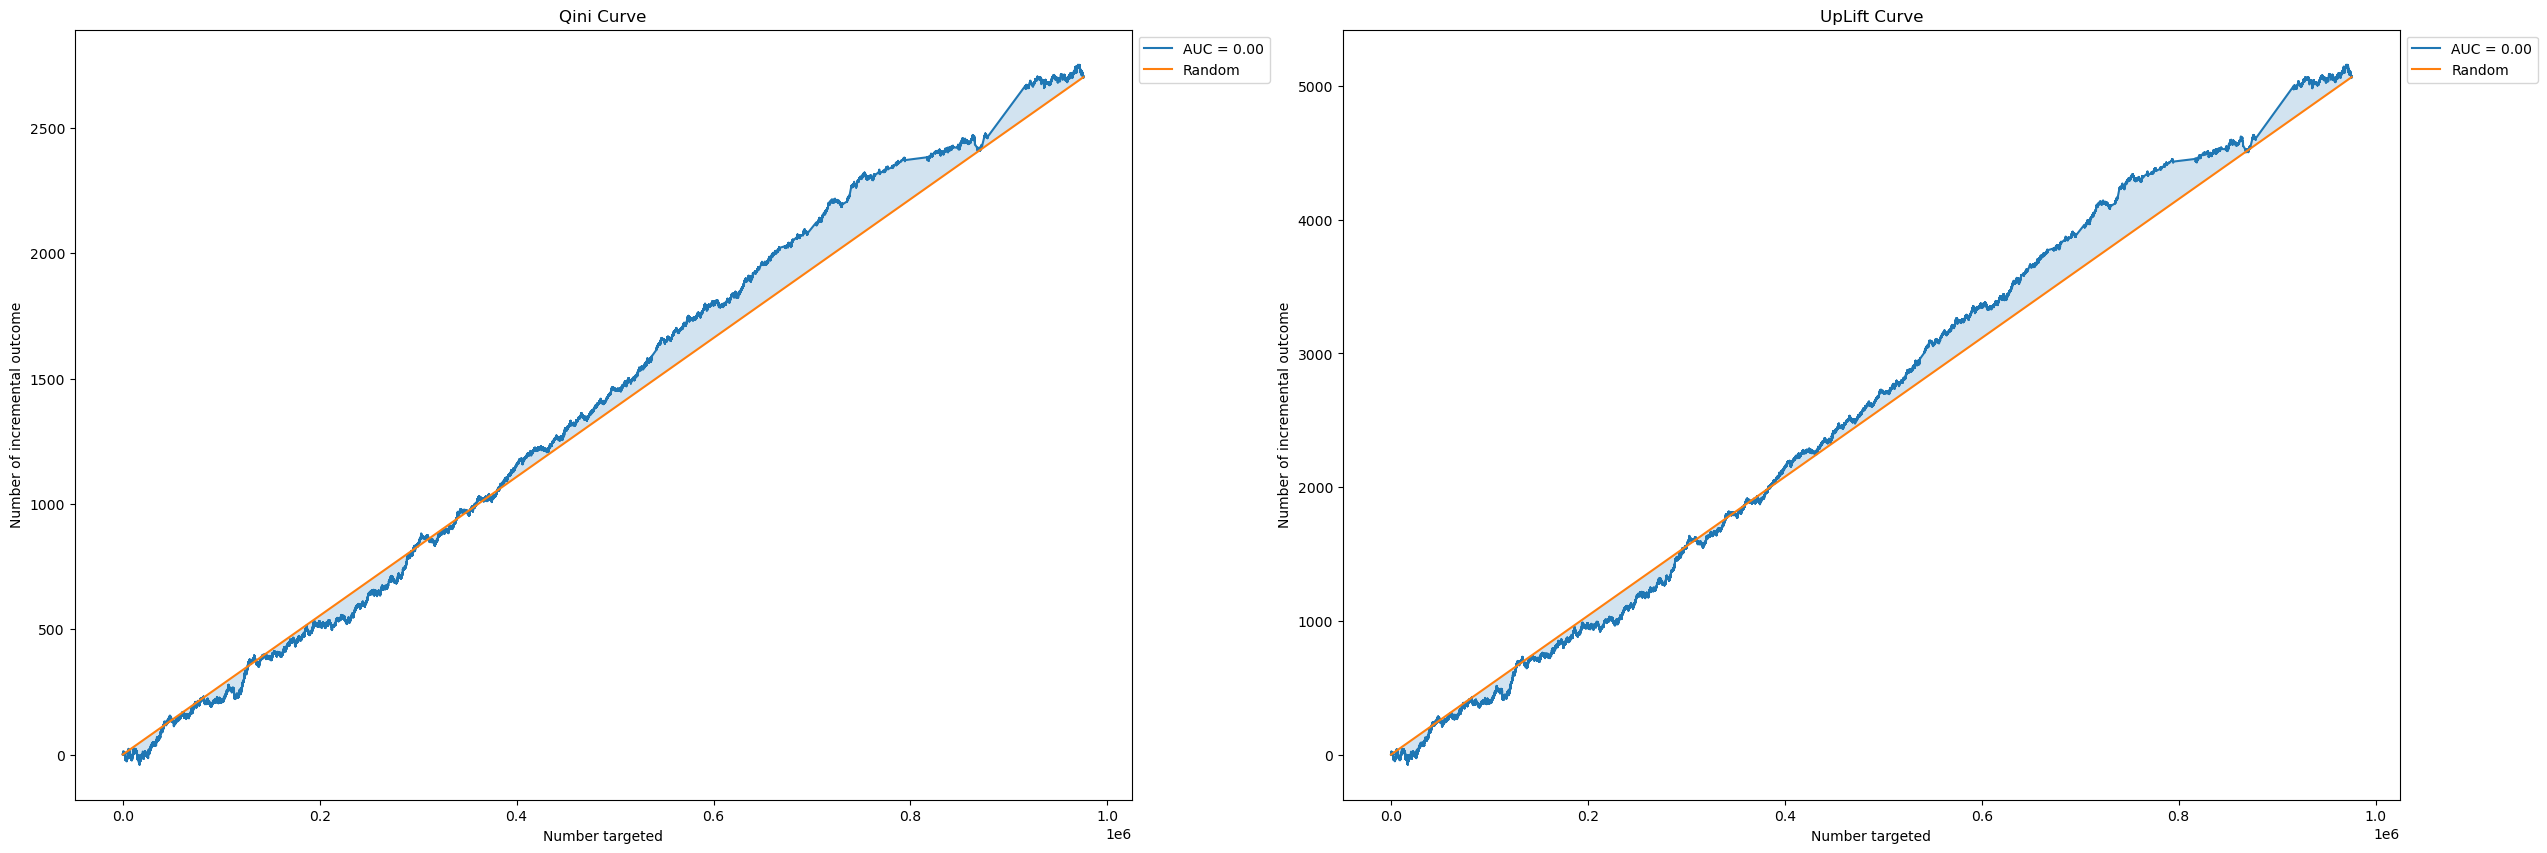

In [17]:
import copy
best_clf  = copy.deepcopy(automl.best_pipeline)
best_clf.fit(X, y)
X_subm[:, -2:] = proc_data.ohe_solomodel.transform(np.zeros(shape = treat_subm.shape).reshape(-1, 1)).toarray()
y_pred0 = best_clf.predict_proba(X_subm)[[1]]
X_subm[:, -2:] = proc_data.ohe_solomodel.transform(np.ones(shape = treat_subm.shape).reshape(-1, 1)).toarray()
y_pred1 = best_clf.predict_proba(X_subm)[[1]]
y_pred = np.squeeze(y_pred1 - y_pred0).tolist()
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_subm, treat_subm, y_pred, f"Plots/CLassification EvalML model Subm.png")
gc.collect()



## Subm Best Regrression Pipeline

In [18]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [19]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [20]:
ranks.to_csv('evalml_res.csv', index = False)

In [21]:
ranks.head()

,pipeline_name,validation_score,percent_better_than_baseline,parameters
0,CatBoost Regressor w/ Replace Nullable Types T...,0.270921,0.003873,{'Imputer': {'categorical_impute_strategy': 'm...
1,Elastic Net Regressor w/ Replace Nullable Type...,0.270925,0.002225,{'Imputer': {'categorical_impute_strategy': 'm...
2,Mean Baseline Regression Pipeline,0.270931,0.000000,{'Baseline Regressor': {'strategy': 'mean'}}
3,Elastic Net Regressor w/ Replace Nullable Type...,0.270931,0.000000,{'Imputer': {'categorical_impute_strategy': 'm...
6,Random Forest Regressor w/ Replace Nullable Ty...,0.270952,-0.007626,{'Imputer': {'categorical_impute_strategy': 'm...


In [22]:
ranks.shape

(13, 4)

In [23]:

ranks.head(10).to_excel('res.xlsx')

In [24]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [3,
   5,
   11,
   14,
   18,
   19,
   20,
   22,
   23,
   25,
   26,
   27,
   28,
   30,
   33,
   35,
   36,
   37,
   40,
   43,
   45,
   46,
   47,
   48,
   49,
   50]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [25]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [26]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
df_subm.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.fit(pd.concat([df, df_subm]))
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()



C:\Users\Kirill\AppData\Local\Temp\ipykernel_17232\2452901922.py:6: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



,SEGMENT_N,SUB_EMAIL,target,treat,lftm_type,NewComer,Тип карты,Канал регистрации,AGE,AMOUNT,ORDERS,AOV,last_order_days,LTV_1M,AO_per_month,GET_Bonus,USE_Bonus,NON_SPEND_BONUS,BASE_GET_Bonus,BASE_USE_Bonus,Express_GET_Bonus,Express_USE_Bonus,Camp_GET_Bonus,REG_GET_Bonus,Camp_BASE_GET_Bonus,REG_BASE_GET_Bonus,AVG_DIS,AVG_USE_BONUS,DISC_AMOUNT,DISC_ORDERS,BASE_AVG_DIS,BASE_AVG_USE_BONUS,BASE_DISC_AMOUNT,BASE_DISC_ORDERS,Express_AVG_DIS,Express_AVG_USE_BONUS,Express_DISC_AMOUNT,Express_DISC_ORDERS,min_days_between,max_days_between,avg_days_between
7727314307,3,Да,0,0,NewComer,1,Как карточное платежное средство,Розница,NaN,3403.4,2.0,1701.7,50.0,850.85,0.50,536.0,502.0,34.0,36.0,2.0,500.0,500.0,NaN,36.0,NaN,36.0,0.133248,502.0,3265.4,1.0,0.000612,2.0,3265.4,1.0,0.132788,500.0,3265.4,1.0,-5.0,-5.0,-5.0
7721696179,2,Нет,0,0,NewComer,0,Без возможности оплаты,Ecomm,51.0,NaN,0.0,NaN,NaN,NaN,0.00,1300.0,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7727261180,-1,Да,0,0,NewComer,1,Как карточное платежное средство,Ecomm,32.0,NaN,4.0,NaN,8.0,NaN,1.00,4000.0,2500.0,1500.0,NaN,NaN,4000.0,2500.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,NaN,NaN,NaN,NaN,0.999200,1250.0,NaN,2.0,-38.0,0.0,-12.0
7725642339,1,Нет,0,1,NewComer,0,Как карточное платежное средство,Ecomm,NaN,959.2,1.0,959.2,68.0,239.80,0.25,510.0,NaN,NaN,10.0,NaN,500.0,NaN,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7720389215,1,Нет,0,1,NewComer,0,Без возможности оплаты,Розница,NaN,1603.0,1.0,1603.0,105.0,400.75,0.25,517.0,NaN,NaN,17.0,NaN,500.0,NaN,NaN,17.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
7727314307,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.36,0.084253,-0.077453,0.506414,-0.273705,-0.077453,0.506414,-0.130555,0.275526,-0.682034,-0.124791,-0.436670,-0.209122,0.306580,-0.972251,-0.063183,-0.972251,-0.063183,0.981466,0.076043,-0.403464,-0.519491,0.042222,-0.389077,0.884508,0.184259,-0.311862,0.953896,0.533180,0.779290,0.133248,0.000612,0.132788
7721696179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.51,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,1.982875,-1.417073,-0.790435,-0.458927,-0.447166,2.187232,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7727261180,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.32,-1.362934,-0.703778,1.960542,-0.826168,-0.703778,1.960542,9.451803,7.012203,3.991963,-0.458927,-0.447166,10.274926,8.046202,-0.972251,-0.719022,-0.972251,-0.719022,5.455291,-0.767560,0.937131,-0.536863,-0.711199,-1.830400,5.853015,-0.830178,1.524437,-0.327282,0.742982,0.471344,0.999200,0.000000,0.999200
7725642339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.36,0.704476,-0.527257,-0.220651,-0.514760,-0.527257,-0.220651,-0.202478,-1.417073,-0.790435,-0.366111,-0.447166,-0.209122,-1.628325,-0.972251,-0.536845,-0.972251,-0.536845,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7720389215,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.36,1.979379,-0.408779,-0.220651,-0.305749,-0.408779,-0.220651,-0.183114,-1.417073,-0.790435,-0.301140,-0.447166,-0.209122,-1.628325,-0.972251,-0.409320,-0.972251,-0.409320,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000


,target,treat
7727314307,0,0
7721696179,0,0
7727261180,0,0
7725642339,0,1
7720389215,0,1


0

In [27]:
X_data_subm, Y_data_subm = proc_data.preprocessing_data(df_subm)
display(X_data_subm.head()) 
display(Y_data_subm.head()) 
gc.collect()
treat_subm = Y_data_subm.treat.values
targ_subm = Y_data_subm.target.values

X_subm = X_data_subm.values
y_subm = Y_data_subm.target * (Y_data_subm.treat - p) / (1- p) / p
y = y_subm.values.astype(float)
gc.collect()



,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
7729487440,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.36,-1.638589,-0.703778,-0.947715,-0.826168,-0.703778,-0.947715,-0.783394,-1.417073,-0.790435,-0.458927,-0.447166,-0.808211,-1.628325,-0.972251,-0.719022,-0.972251,-0.719022,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7724975778,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.54,0.704476,-0.101322,0.506414,-0.294759,-0.101322,0.506414,0.693794,0.319358,0.226622,-0.143354,-0.368446,0.689511,0.306580,-0.972251,-0.099619,-0.972251,-0.099619,1.059220,-0.285926,-0.403464,-0.406576,-0.281052,-0.389077,0.884508,-0.251010,-0.311862,-0.016694,-0.515831,-0.320518,0.216450,0.007981,0.211479
7715433861,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.40,2.082750,0.225431,-0.220651,0.813087,0.225431,-0.220651,2.123955,0.268782,1.922779,0.014433,-0.447166,2.187232,0.306580,-0.972251,0.210083,-0.972251,0.210083,0.969504,0.536894,-0.403464,-0.536863,-0.711199,-1.830400,0.884508,0.738434,-0.311862,1.148014,0.742982,0.999252,0.090102,0.000000,0.090102
7728251646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.36,0.670019,-0.694760,-0.220651,-0.810260,-0.694760,-0.220651,-0.780628,-1.417073,-0.790435,-0.449645,-0.447166,-0.808211,-1.628325,-0.972251,-0.700804,-0.972251,-0.700804,-2.021021,-0.767560,-1.744059,-0.536863,-0.711199,-1.830400,-2.427831,-0.830178,-2.148161,1.148014,0.742982,0.999252,0.000000,0.000000,0.000000
7711651230,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.25,0.463278,-0.176093,-0.220651,0.104743,-0.176093,-0.220651,0.956589,-0.405560,1.214984,-0.189762,-0.447166,0.989055,-0.467382,-0.972251,-0.190708,-0.972251,-0.190708,-0.226706,-0.026779,-0.403464,-0.536863,-0.711199,-1.830400,-0.440428,0.060615,-0.311862,1.148014,0.742982,0.999252,0.094714,0.000000,0.094714


,target,treat
7729487440,0,1
7724975778,0,0
7715433861,0,1
7728251646,0,1
7711651230,0,1


0

UpLift at 30%: overall - 0.005254, grouped - 0.006084.
Qini AUC Score: 0.000226; UpLift AUC Score: -1.5e-05


145

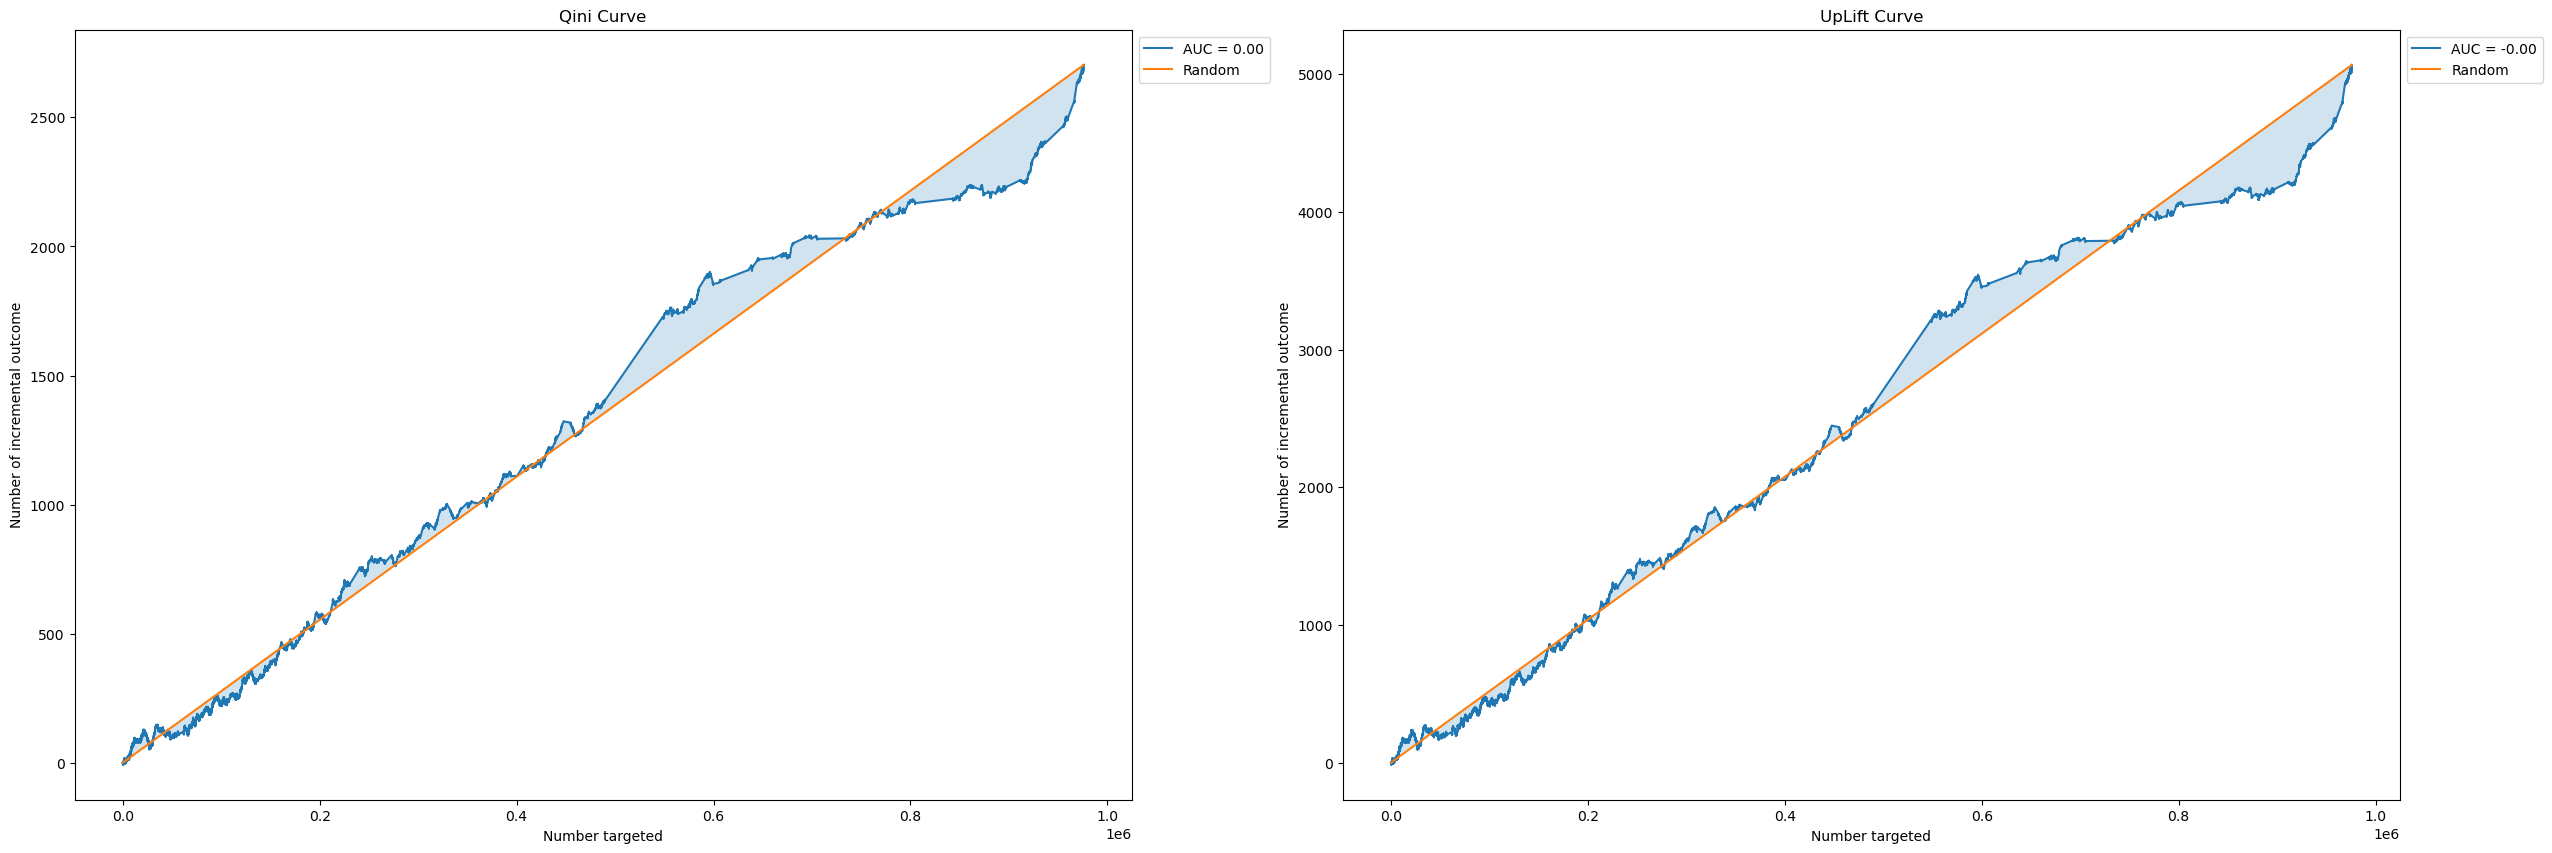

In [28]:
import copy

ctbst  = copy.deepcopy(automl.best_pipeline)
ctbst.fit(X, y)
y_pred = ctbst.predict(X_subm)
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(targ_subm, treat_subm, y_pred, f"Plots/Trasnform Regression EvalML Subm model.png")
gc.collect()

